In [2]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.2 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:41:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7775408670931059

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      1033
           1       0.60      0.51      0.55       374

    accuracy                           0.78      1407
   macro avg       0.71      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407


Confusion Matrix:
 [[903 130]
 [183 191]]


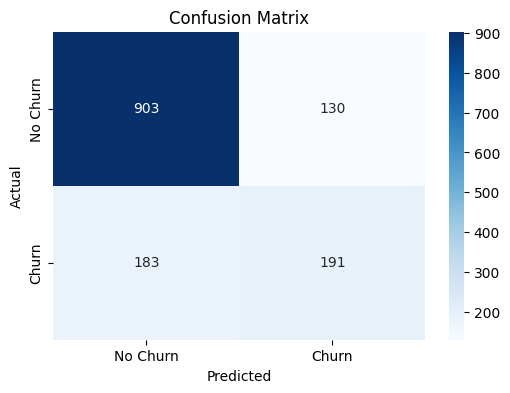

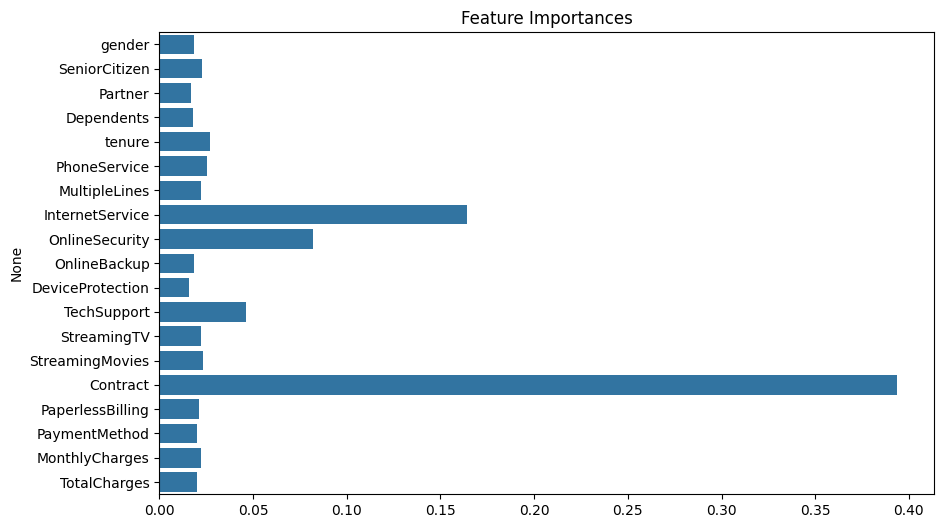

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("../../data/customer-churn.csv")

# Convert TotalCharges to numeric (handle errors)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

# Drop rows with missing TotalCharges
df.dropna(subset=["TotalCharges"], inplace=True)

# Drop customerID as it's not useful
df.drop("customerID", axis=1, inplace=True)

# Encode target variable
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# Encode categorical features
cat_cols = df.select_dtypes(include="object").columns
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Train-test split
X = df.drop("Churn", axis=1)
y = df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print results
print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", conf_matrix)

# 🔵 Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 🔵 Feature importance plot
plt.figure(figsize=(10, 6))
sns.barplot(x=model.feature_importances_, y=X.columns)
plt.title("Feature Importances")
plt.show()

# 🔵 Save predictions
results = X_test.copy()
results["Churn_Actual"] = y_test
results["Churn_Predicted"] = y_pred
results["Churn_Probability"] = y_proba
results.to_csv("../../data/churn_predictions.csv", index=False)


In [ ]:
#Creating the prediction model for streamlit app

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Correct path to the uploaded Excel file
file_path = "../../data/customer-churn.csv"

# Load dataset
df = pd.read_csv(file_path)

# Drop customerID and handle missing data
df.drop('customerID', axis=1, inplace=True)
df.replace(" ", np.nan, inplace=True)
df.dropna(inplace=True)

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

# Encode categorical variables
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    if col != 'Churn':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Encode target column
target_le = LabelEncoder()
df['Churn'] = target_le.fit_transform(df['Churn'])
label_encoders['Churn'] = target_le

# Train-test split
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Save model and encoders
joblib.dump(model, "../streamlit-app/xgb_churn_model.pkl")
joblib.dump(label_encoders, "../streamlit-app/label_encoders.pkl")

# Optional: print evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:41:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1033
           1       0.60      0.51      0.55       374

    accuracy                           0.78      1407
   macro avg       0.71      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407

